# **Зачетный проект**


## Цель данной работы заключается в исследовании датасета «Exploring Mental Health Data», полученного с платформы Kaggle, а также в обучении простой модели (градиентного бустинга) для достижения оптимальных показателей оценки качества модели

Работа будет разделена на две основные части:

1. Анализ и исследование данных: Первая часть сосредоточена на изучении самого датасета, его структуры, распределений, закономерностей и особенностей. Основная цель — глубже понять данные и выявить значимые закономерности

2. Предобработка данных и обучение модели: Вторая часть включает подготовку датасета для моделирования, включая очистку данных, их трансформацию и feature engineering, а также обучение модели catboost

# Часть 1


In [1]:
# Для начала импортируем все нужные библиотеки, а также скачаем датасет

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


Датасет посвящен изучению аспектов психического здоровья, включая условия труда, отношения сотрудников к своей работе, а также доступность и восприятие психиатрической помощи. В нем представлены данные о респондентах, их демографии, профессиональных сферах, а также ответы на вопросы, связанные с психическим благополучием. Основная цель — выявление факторов, влияющих на психическое здоровье на рабочем месте, и понимание барьеров для получения помощи​. Данный датасет был сгенерирован искусственно с помощью нейронной сети

In [2]:
# Загрузим наш датасет и посмотрим как он выглядит
df = pd.read_csv('/content/depression.csv')

# Первым делом удалю колонку id, она тут бесполезна и в анализе никак не поможет

df = df.iloc[:, 1:]
df.head(3)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1


In [3]:
# Выведем кратко информацию о данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  

In [4]:
# Посмотрим кол-во пропусков в наших данных

df.isnull().sum()

,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,36630
Academic Pressure,112803
Work Pressure,27918
CGPA,112802
Study Satisfaction,112803


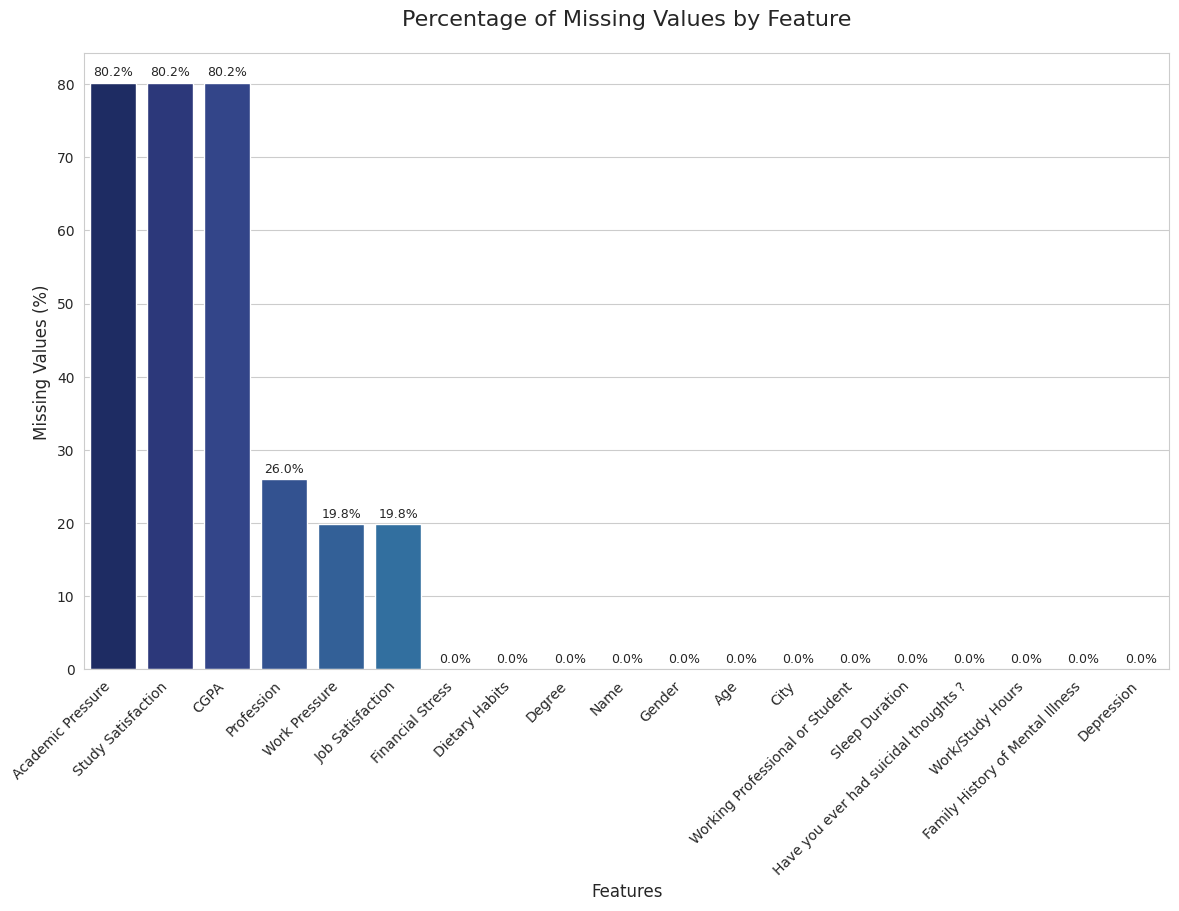

In [5]:
# Построим график с долей пропущенных значений в колонке
# Далее подробнее разберем что же влияет на наличие депрессии

# Считаем кол-во пропусков в каждой из колонок
missing_values = df.isnull().sum()

# Считаем проценты
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'missing_values': missing_values,
    'missing_percent': missing_percent,
})

# Сортируем по убыванию
missing_df = missing_df.sort_values(by='missing_percent', ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(14, 8))

ax = sns.barplot(
    data=missing_df,
    x=missing_df.index,
    y='missing_percent',
    palette="YlGnBu_r"
)

# Выводим проценты
for p in ax.patches:
    percentage = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        percentage + 0.5,
        f'{percentage:.1f}%',
        ha="center",
        va='bottom',
        fontsize=9
    )

plt.title('Percentage of Missing Values by Feature', fontsize=16, pad=20)
plt.ylabel('Missing Values (%)', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.show()

# В первых четырёх столбцах большое количество пропусков
# В дальнейшем мы займёмся этим и заполним недостающие данные

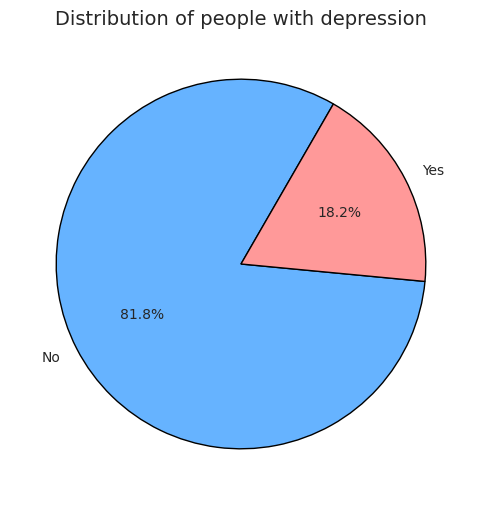

In [6]:
# Посмотрим сбалансированность классов, равны ли доли людей с депрессией и без?

depression_stats = df['Depression'].value_counts()
colors = ['#66b3ff', '#ff9999']

# Построение pie диаграммы
plt.figure(figsize=(8, 6))
plt.pie(depression_stats, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=60, colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

plt.title("Distribution of people with depression", fontsize=14)

plt.show()

# Можно заметить, что количество людей с депрессией значительно меньше, чем тех, у кого её нет

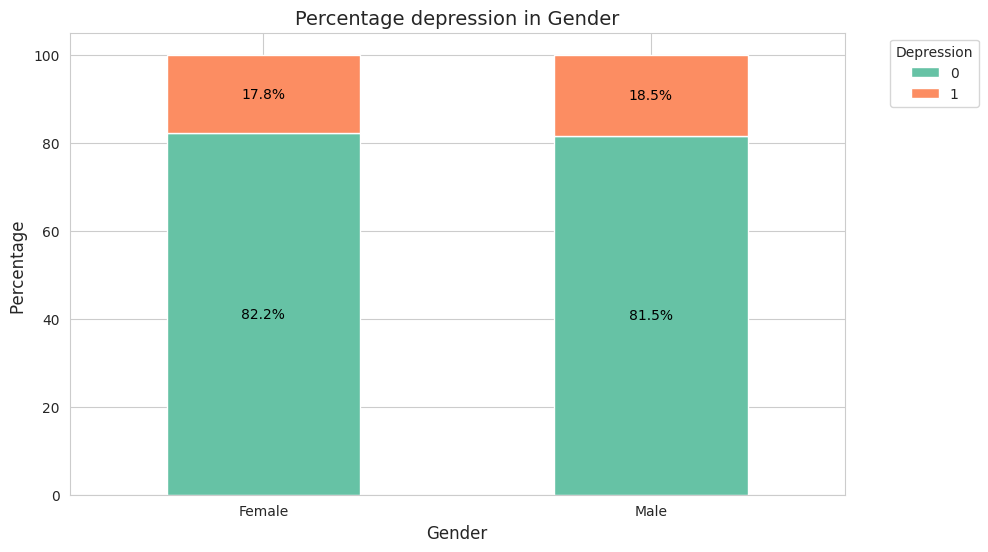

In [7]:
# Построим что-нибудь интереснее, к примеру долю депрессии среди мужчин и женщин

gender_counts = df.groupby(['Gender', 'Depression']).size().unstack()
gender_percentage = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

# Установка стиля и цветовой палитры
sns.set_style("whitegrid")
colors = sns.color_palette("Set2")

# Построение графика
ax = gender_percentage.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(10, 6)
)

plt.ylabel('Percentage ', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.title('Percentage depression in Gender', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Выводим проценты
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(
        x + width / 2,
        y + height / 2,
        f'{height:.1f}%',
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

plt.legend(
    title='Depression',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10
)

plt.show()

# В этом случае сложно сделать однозначный вывод, так как показатели примерно одинаковы

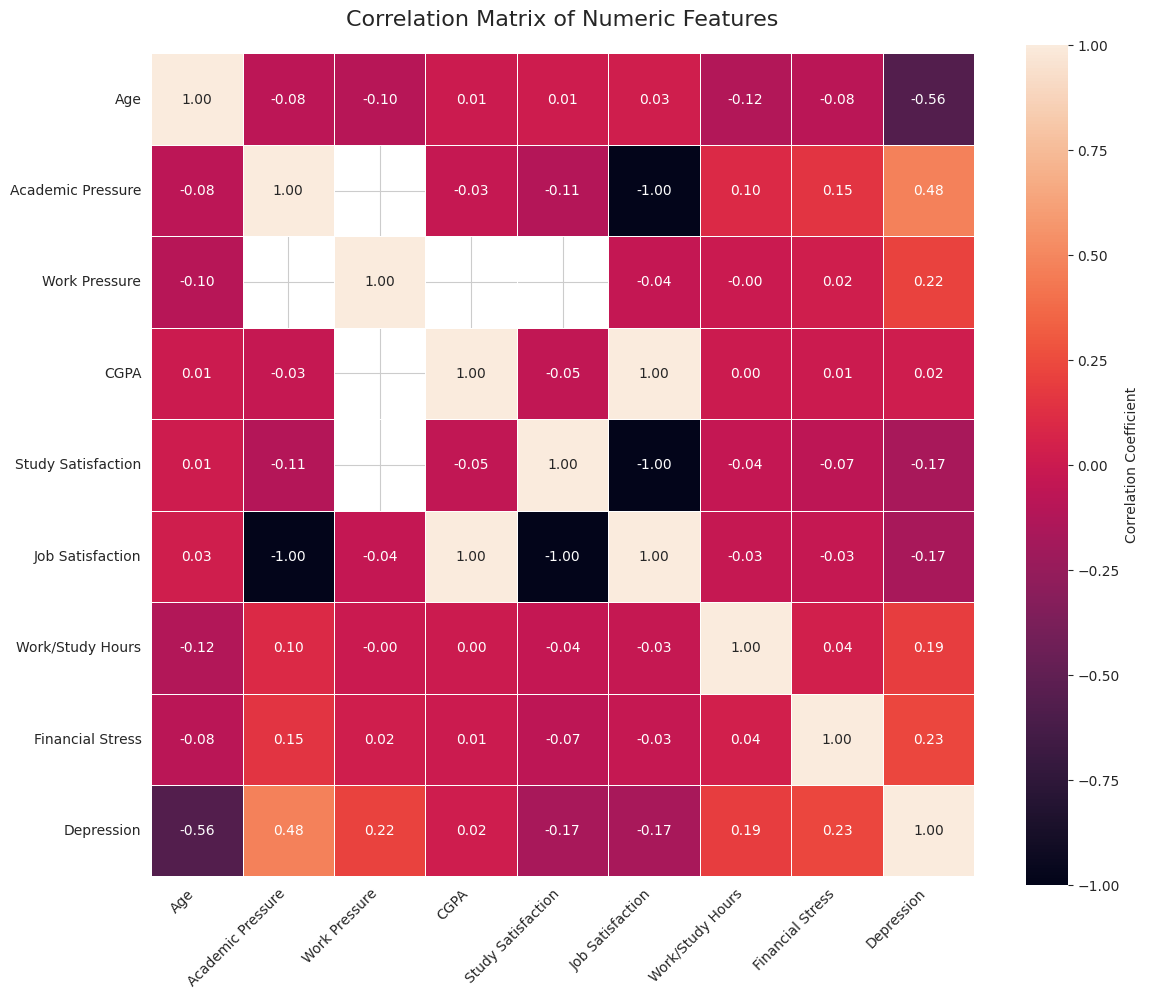

In [8]:
# Попытаемся выудить какие-либо зависимости, построим corr матрицу для числовых колонок

# Выбираем только колонки с числовыми значениями
numeric_col = df.select_dtypes(include=['int64', 'float64']).columns

# Считаем corr матрицу
corr_matrix = df[numeric_col].corr()

plt.figure(figsize=(12, 10))

# Строим heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=0.5,
    square=True
)

plt.title('Correlation Matrix of Numeric Features', fontsize=16, pad=20)
plt.xticks(fontsize=10, rotation=45, ha='right')  # Настройка подписи осей
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()

plt.show()

# Эта тепловая карта показывает, что депрессия имеет наибольшую корреляцию с возрастом и работой
# Однако это указывает лишь на наличие слабой линейной зависимости
# Это не исключает возможной зависимости с другими колонками, которая может быть нелинейной, к примеру квадратичной
# Грубо говоря, можно сказать, что депрессия у младшего поколения распространена сильнее, чем у более старшего

Интересно исследовать, как профессия влияет на наличие депрессии и связаны ли суицидальные мысли с депрессией. Возможно, существуют профессии, которые особенно подвержены депрессии. Может быть, на это влияет уровень стресса или количество работы? Возможно, у тех, кто много работает, просто нет времени на депрессию? А может, свою роль играет семья, или время сна? Давайте изучим эти вопросы с помощью визуализаций,
это же так наглядно и удобно!


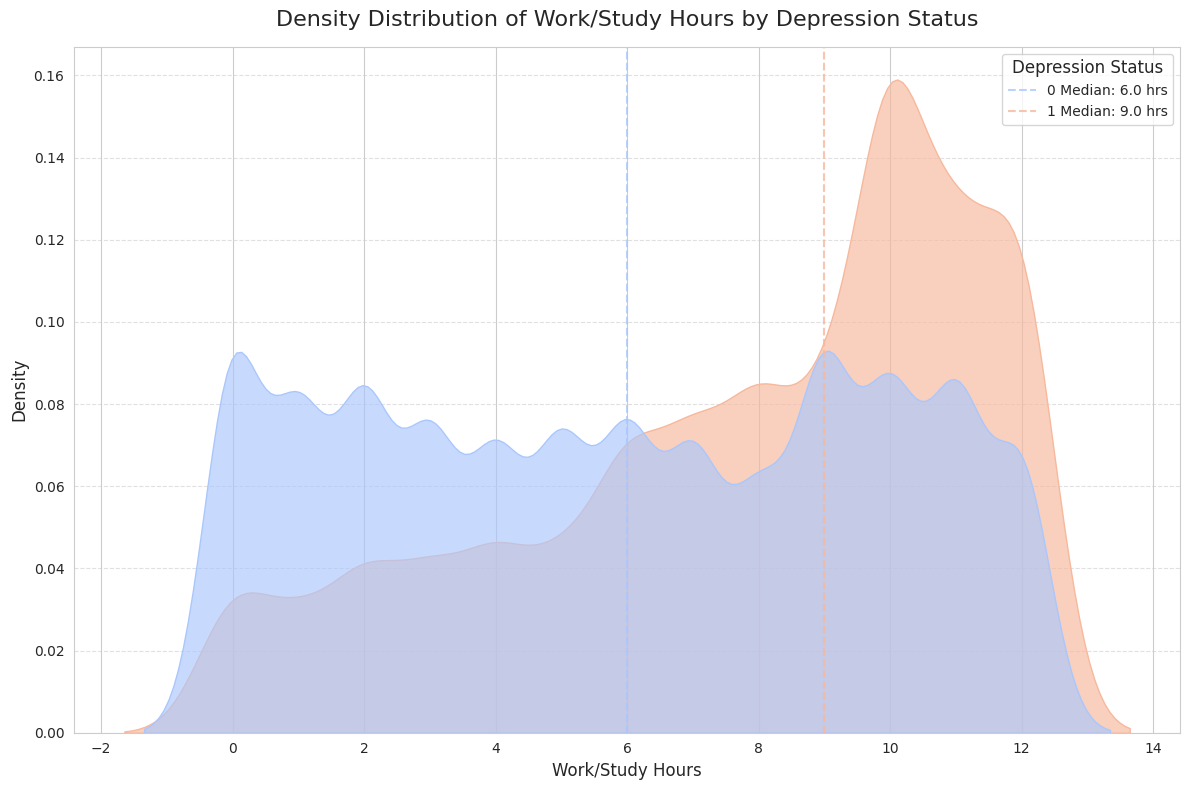

In [9]:
# Для начала построим два похожих, но от этого не менее информативных графика

plt.figure(figsize=(12, 8))

# Строим KDE график, seaborn это круто <3
sns.kdeplot(
    data=df,
    x='Work/Study Hours',
    hue='Depression',
    fill=True,
    common_norm=False,
    bw_adjust=1.2,
    palette='coolwarm',
    alpha=0.65
)

# Тут добавляем медианное значение, для большей наглядности
for group, color in zip(df['Depression'].unique(), sns.color_palette('coolwarm', len(df['Depression'].unique()))):
    median_value = df[df['Depression'] == group]['Work/Study Hours'].median()
    plt.axvline(median_value, color=color, linestyle='--', linewidth=1.5, alpha=0.8, label=f'{group} Median: {median_value:.1f} hrs')

plt.title('Density Distribution of Work/Study Hours by Depression Status', fontsize=16, pad=15)
plt.xlabel('Work/Study Hours', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(title='Depression Status', fontsize=10, title_fontsize=12, loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

# График показывает, что большое количество рабочих часов может влиять на развитие депрессии
# К сожалению, у трудоголиков вероятность возникновения депрессии выше, чем у людей, работающих по 6 часов


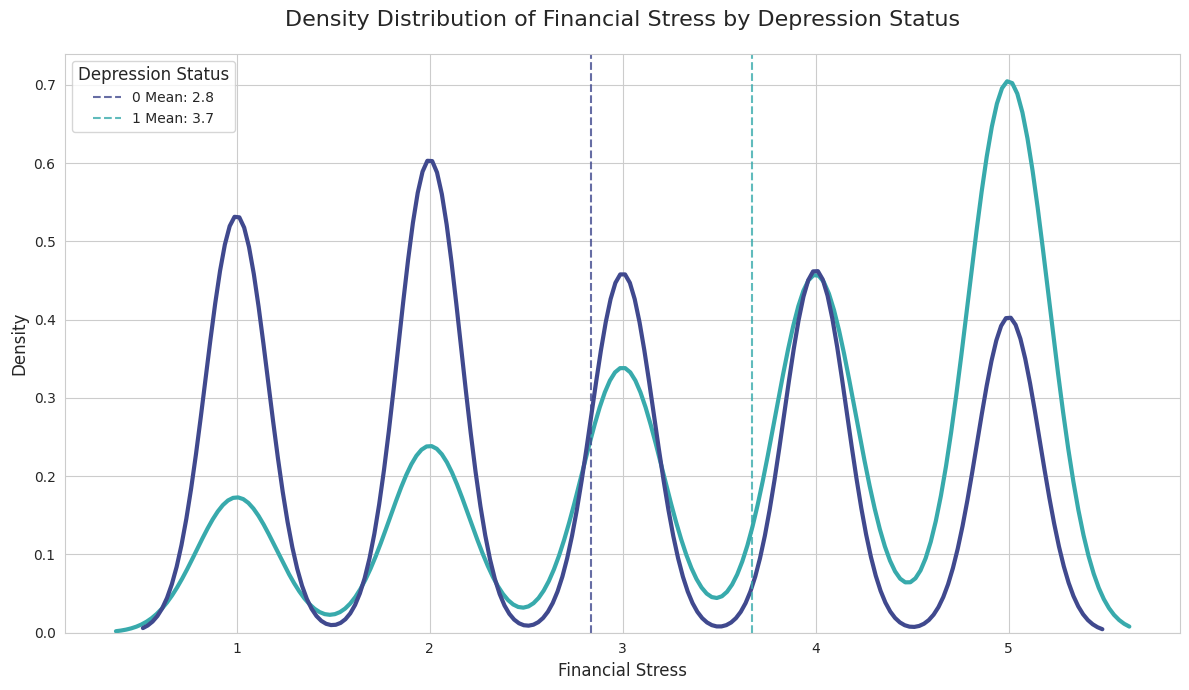

In [10]:
# Построим похожий график, однако теперь вместо часов работы будет уровень стресса

plt.figure(figsize=(12, 7))

# KDE график
sns.kdeplot(
    data=df,
    x='Financial Stress',
    hue='Depression',
    fill=False,  # Убираем заполнение
    common_norm=False,
    bw_adjust=1.2,
    palette='mako',
    linestyle='-',
    linewidth=3
)

# Возьмем теперь средние значения, а не медиану
for group, color in zip(df['Depression'].unique(), sns.color_palette('mako', len(df['Depression'].unique()))):
    mean_value = df[df['Depression'] == group]['Financial Stress'].mean()
    plt.axvline(mean_value, color=color, linestyle='--', linewidth=1.5, alpha=0.8, label=f'{group} Mean: {mean_value:.1f}')

plt.title('Density Distribution of Financial Stress by Depression Status', fontsize=16, pad=20)
plt.xlabel('Financial Stress', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(title='Depression Status', fontsize=10, title_fontsize=12, loc='upper left')

plt.tight_layout()

plt.show()

# Можно сделать вывод, что люди, страдающие от депрессии, более подвержены стрессу, чем люди без депрессии

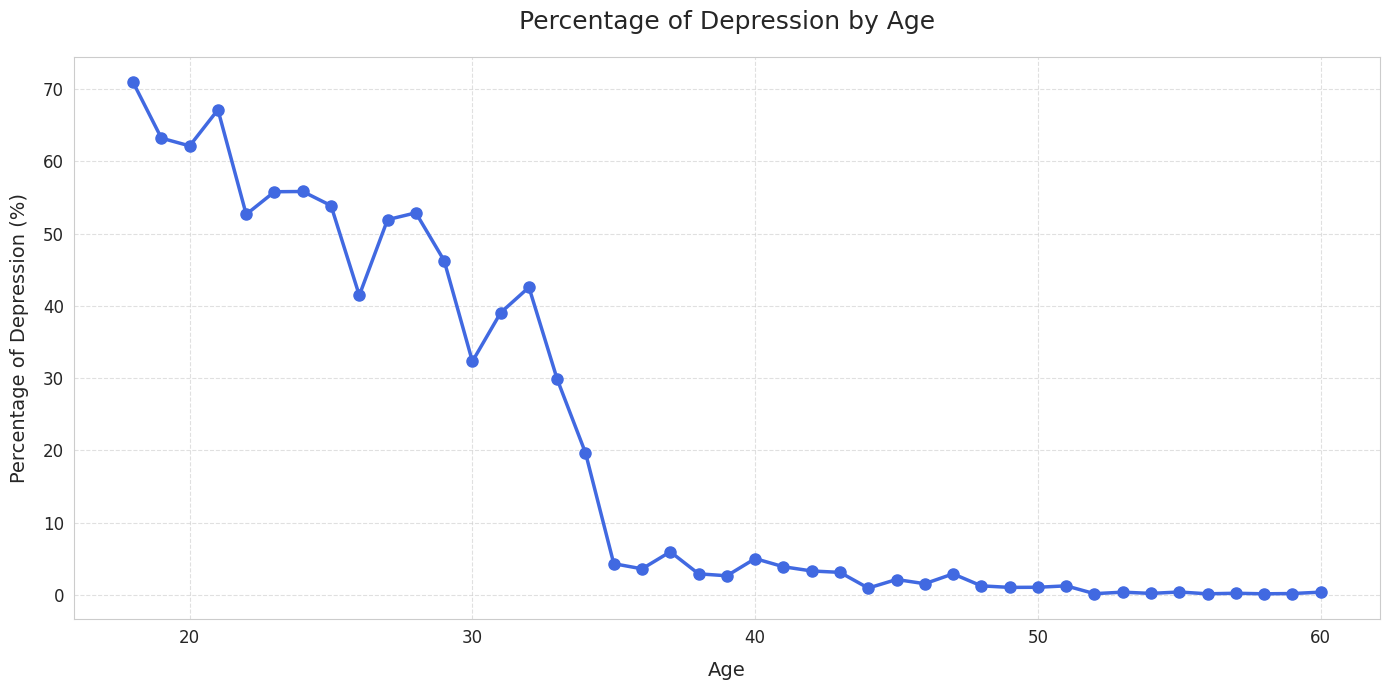

In [11]:
# Проанализируем, как возраст влияет на наличие депрессии. Правда ли, что молодые люди чаще страдают от этого недуга?
# Однако данные несбалансированные: если людей в возрасте 60+ больше всего, и они сильнее остальных подвержены депрессии
# Это ещё ни о чём не говорит. В количественном отношении это может быть незначительным показателем,
# Ведь молодых людей 18 лет может быть гораздо меньше, но при этом все они могут страдать депрессией
# Чтобы исправить эту ситуацию, мы будем считать процент людей от общего количества лиц определённого возраста

age_with_depression = df[df['Depression'] == 1]['Age'].value_counts().sort_index()
depression_percentage = (age_with_depression / df['Age'].value_counts() * 100)

plt.figure(figsize=(14, 7))

# Строим график
plt.plot(
    depression_percentage.index,
    depression_percentage.values,
    marker='o',
    linestyle='-',
    color='royalblue',
    linewidth=2.5,
    markersize=8,
)

plt.title('Percentage of Depression by Age', fontsize=18, pad=20)
plt.xlabel('Age', fontsize=14, labelpad=10)
plt.ylabel('Percentage of Depression (%)', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

# Как видим, у подростков действительно чаще наблюдается депрессия, чем у представителей старшего поколения
# Так, 70% подростков в возрасте 18 лет страдают от депрессии

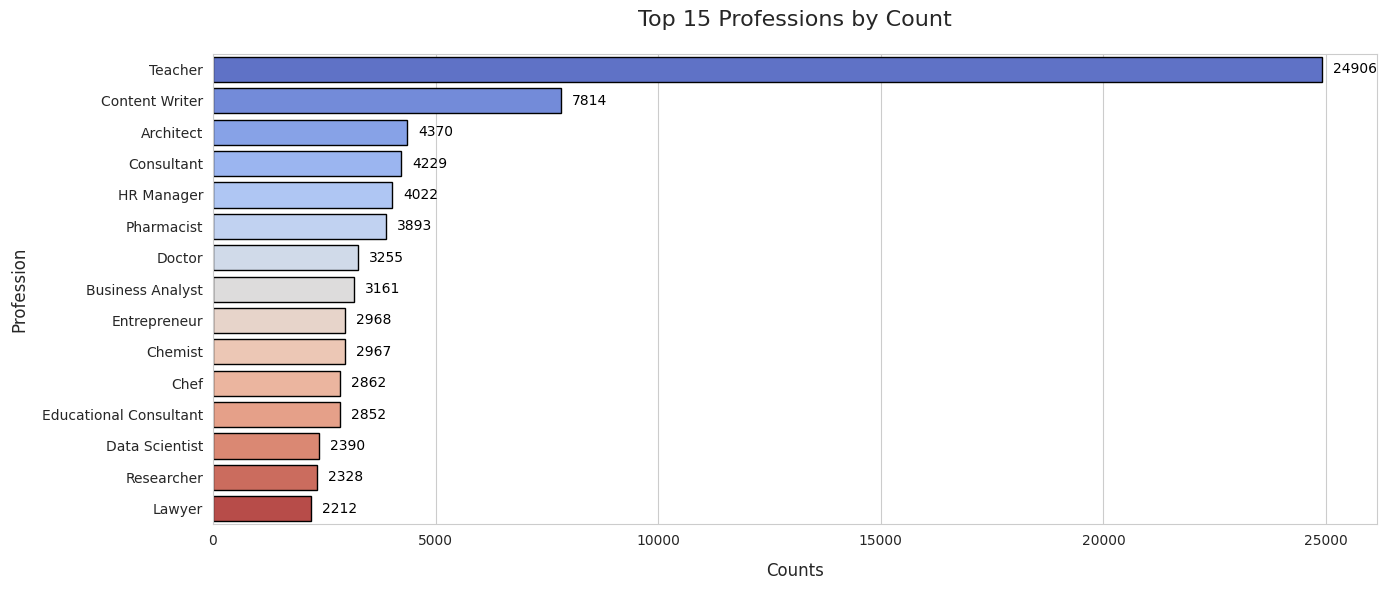

In [12]:
# Мы повторим этот анализ, но уже для профессий
# Сначала определим, какая профессия является наиболее распространённой

# Выбираем топ-15 профессий
professions_15 = df['Profession'].value_counts().head(15)

plt.figure(figsize=(14, 6))

# Тут график рисуем
sns.barplot(
    x=professions_15.values,
    y=professions_15.index,
    palette='coolwarm',
    edgecolor='black',
    linewidth=1
)

plt.title('Top 15 Professions by Count', fontsize=16, pad=20)
plt.xlabel('Counts', fontsize=12, labelpad=10)
plt.ylabel('Profession', fontsize=12, labelpad=10)

# Добавляем кол-во людей к каждой из профессий
for index, value in enumerate(professions_15.values):
    plt.text(
        value + max(professions_15.values) * 0.01,  # Сдвиг текста чуть правее столбца
        index,
        f'{value}',
        ha='left',
        va='center',
        fontsize=10,
        color='black'
    )

plt.tight_layout()

plt.show()

# Судя по имеющимся данным, наиболее частой профессией является учитель

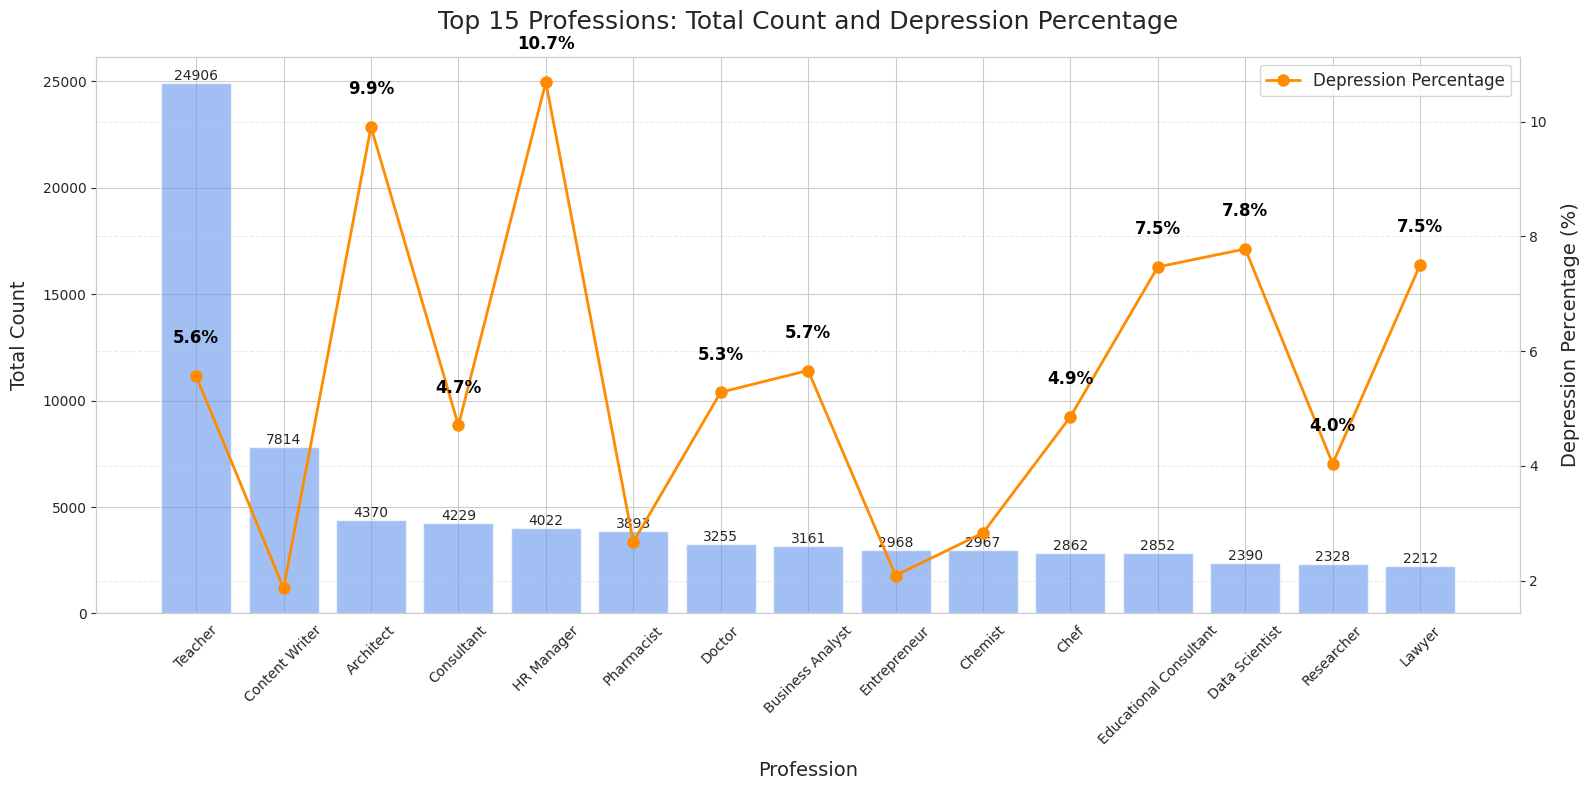

In [13]:
# Теперь мы создадим график, который покажет наличие депрессии у людей разных профессий

# Считаем общее количество людей по профессиям (берем топ-15)
professions_counts = df['Profession'].value_counts().head(15)

# Считаем количество людей с депрессией только для профессий из топ-15
professions_with_depression = df[df['Profession'].isin(professions_counts.index) & (df['Depression'] == 1)][
    'Profession'].value_counts()

# Это необходимо для того, чтобы выровнять индексы
# Если присмотреться, то в professions_counts и professions_with_depression профессии распределены по-разному
# Это приводит к ошибке при подсчёте долей людей с депрессией относительно общего числа представителей каждой профессии
professions_with_depression = professions_with_depression.reindex(professions_counts.index)

# Рассчитываем процент людей с депрессией
depression_percentage = (professions_with_depression / professions_counts * 100)

fig, ax1 = plt.subplots(figsize=(16, 8))

# Гистограмма (общее количество людей)
bars = ax1.bar(
    professions_counts.index,
    professions_counts.values,
    color='cornflowerblue',
    alpha=0.6,
)

ax1.set_ylabel('Total Count', fontsize=14, labelpad=10)
ax1.set_xlabel('Profession', fontsize=14, labelpad=10)
ax1.set_title('Top 15 Professions: Total Count and Depression Percentage', fontsize=18, pad=20)
ax1.tick_params(axis='x', rotation=45)

# Линейный график (процент депрессии)
ax2 = ax1.twinx()
line = ax2.plot(
    professions_counts.index,
    depression_percentage.values,
    color='darkorange',
    marker='o',
    markersize=8,
    linewidth=2,
    label='Depression Percentage'
)

ax2.set_ylabel('Depression Percentage (%)', fontsize=14, labelpad=10)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.4)

# Добавляем кол-во людей к гистограммам
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Тут добавляем проценты
for i, value in enumerate(depression_percentage.values):
    if value > 3:
        ax2.text(
            i,
            value + 0.5,
            f'{value:.1f}%',
            ha='center',
            va='bottom',
            color='black',
            fontsize=12,
            fontweight='bold'
        )

plt.tight_layout()

plt.show()

# Из этого графика, видно, что больше всего людей с депрессией среди HR-специалистов и архитекторов
# Для HR это может быть неожиданной проблемой, так как они, вероятно, не смогли найти нужных кандидатов

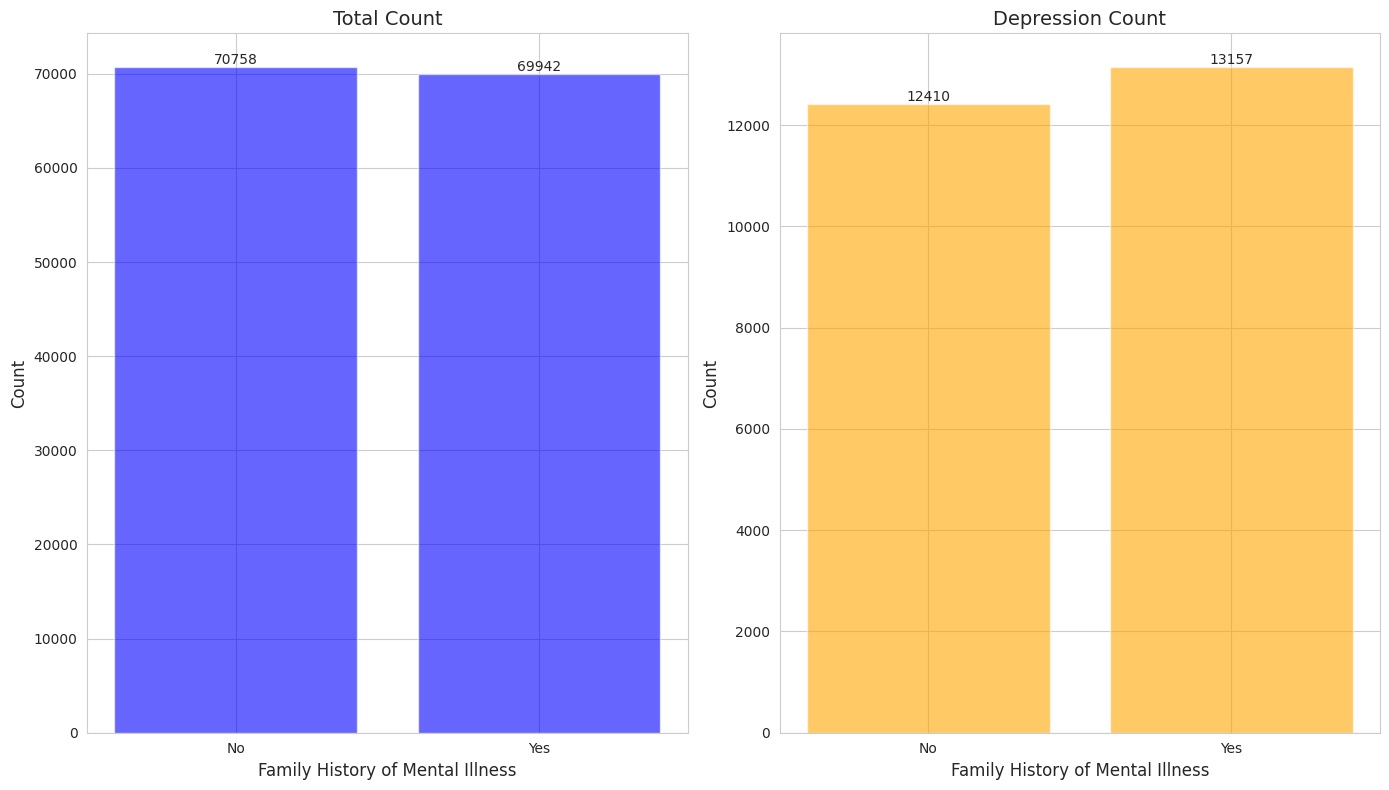

In [14]:
# Теперь проанализируем, как семейная история влияла на наличие депрессии

family = df['Family History of Mental Illness'].value_counts()

# Тут сортируем по индексу, так как Yes и No изменили свой порядок
family_depression = df[df['Depression'] == 1]['Family History of Mental Illness'].value_counts().sort_index()

# Создаем холст с двумя осями
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=True)

# График с Family History of Mental Illness
axes[0].bar(family.index, family.values, color='blue', alpha=0.6)
axes[0].set_title('Total Count', fontsize=14)
axes[0].set_xlabel('Family History of Mental Illness', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Добавляем метки
for idx, value in enumerate(family.values):
    axes[0].text(idx, value + 2, f'{value}', ha='center', va='bottom', fontsize=10)

# График людей с депрессией
axes[1].bar(family_depression.index, family_depression.values, color='orange', alpha=0.6)
axes[1].set_title('Depression Count', fontsize=14)
axes[1].set_xlabel('Family History of Mental Illness', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Добавляем метки
for idx, value in enumerate(family_depression.values):
    axes[1].text(idx, value + 2, f'{value}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.show()

# На основании графиков сложно сделать однозначный вывод, так как различия не существенные

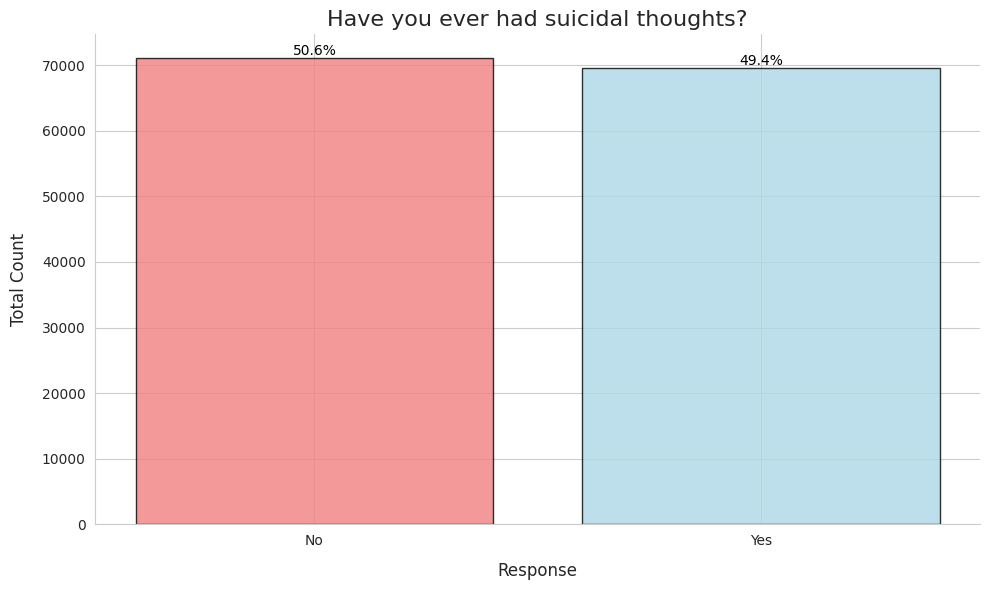

In [15]:
# Хотелось бы понять, какова связь между суицидальными мыслями и депрессией

# Построим для начала гистаграмму с кол-вом людей у которых вообще были такие мысли

suicidal_counts = df['Have you ever had suicidal thoughts ?'].value_counts()

# Считаем проценты
suicidal_percentages = (suicidal_counts / suicidal_counts.sum()) * 100

fig, ax = plt.subplots(figsize=(10, 6))

# Гистограмма
bars = ax.bar(
    suicidal_counts.index,
    suicidal_counts.values,
    color=['lightcoral', 'lightblue'],
    alpha=0.8,
    edgecolor='black'
)

# Добавляем метки
for bar, count, percentage in zip(bars, suicidal_counts.values, suicidal_percentages):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f'{percentage:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

ax.set_ylabel('Total Count', fontsize=12, labelpad=10)
ax.set_xlabel('Response', fontsize=12, labelpad=10)
ax.set_title('Have you ever had suicidal thoughts?', fontsize=16)

# Убираем правую и верхнюю рамки
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

plt.show()

# Как видим показатели почти одинаковы

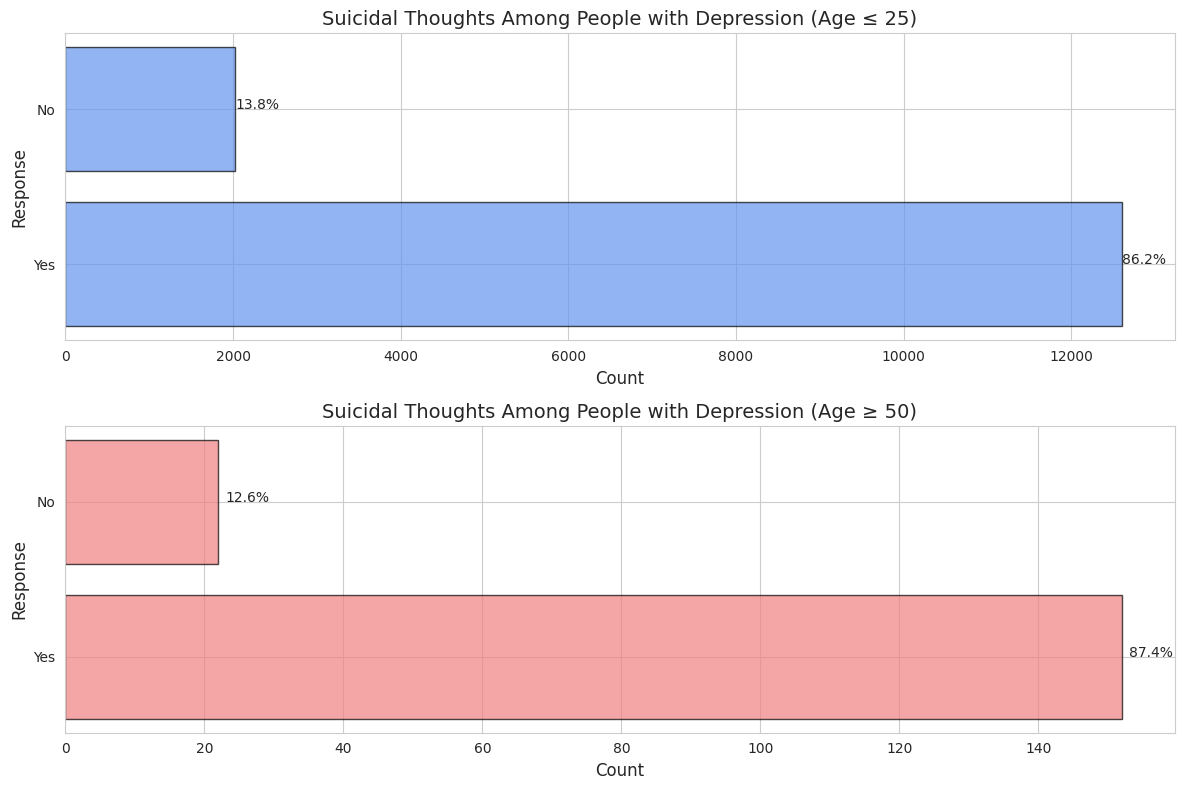

In [16]:
# Попробуем разобраться, как суицидальные мысли влияют на наличие депрессии у представителей разных поколений

# К первому поколению отнесу людей младше 25
# Ко второму поколению людец старше 50

first_depression_suicidal = df[(df['Depression'] == 1) & (df['Age'] <= 25)]['Have you ever had suicidal thoughts ?'].value_counts()
second_depression_suicidal = df[(df['Depression'] == 1) & (df['Age'] >= 50)]['Have you ever had suicidal thoughts ?'].value_counts()

# Вычисляем проценты
first_depression_percent = (first_depression_suicidal / first_depression_suicidal.sum()) * 100
second_depression_percent = (second_depression_suicidal / second_depression_suicidal.sum()) * 100

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Первый график
axes[0].barh(
    first_depression_suicidal.index,
    first_depression_suicidal.values,
    color='cornflowerblue',
    alpha=0.7,
    edgecolor='black'
)

# Добавляем метки
for i, (count, percentage) in enumerate(zip(first_depression_suicidal.values, first_depression_percent)):
    axes[0].text(count + 1, i, f'{percentage:.1f}%', fontsize=10)

axes[0].set_title('Suicidal Thoughts Among People with Depression (Age ≤ 25)', fontsize=14)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Response', fontsize=12)

# Второй график
axes[1].barh(
    second_depression_suicidal.index,
    second_depression_suicidal.values,
    color='lightcoral',
    alpha=0.7,
    edgecolor='black'
)

# Добавляем метки
for i, (count, percentage) in enumerate(zip(second_depression_suicidal.values, second_depression_percent)):
    axes[1].text(count + 1, i, f'{percentage:.1f}%', fontsize=10)

axes[1].set_title('Suicidal Thoughts Among People with Depression (Age ≥ 50)', fontsize=14)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('Response', fontsize=12)

plt.tight_layout()

plt.show()

# Очевидно, что суицидальные мысли оказывают значительное влияние на наличиедепрессии
# Как у младшего поколения, так и у старшего


## *В первой части моей работы был проведен анализ датасета, связанного с депрессией. Описаны исходные данные и их происхождение, а также выдвинуты гипотезы о факторах, влияющих на развитие депрессии. В ходе исследования были построены визуализации и выявлены значимые зависимости. Например, установлено, что депрессия чаще встречается у представителей младшего поколения, чем у старшего, а наличие суицидальных мыслей оказывает существенное влияние на вероятность развития депрессии*

# Часть 2

Во 2 части мы сосредоточимся на предобработке нашего датасета, а также на обучении модели

In [43]:
# Для начала импортируем все нужные библиотеки

%pip install catboost
%pip install optuna

import optuna
from catboost import CatBoostClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score


In [18]:
# Для начала заполним все пропуски

# Для числовых признаковых возьмем просто медианное значение (не самый лучший способ, но лучше чем ничего)
# Для категориальных признаков заполним все пропуски значением 'Unknown'

features = df.columns[: -1]
cat_features = df.select_dtypes(include=[object]).columns
num_features = df.select_dtypes(include=['int64', 'float64']).columns
target = 'Depression'

# Заменяем пустые значения в каждой из категориальных колонок
for col in cat_features:
    df[col].fillna('Unknown', inplace=True)

# Заменяем пустые значения на медиану в числовых колонках
for col in num_features:
    df[col].fillna(df[col].median(), inplace=True)


In [19]:
# Нужно преобразовать категориальные признаки
# Может быть labelencoding, или же one hot encoding, а может и вовсе target encoding?
# Благо catBoost умеет работать с такими признаками, используя упорядоченное кодирование (ordered encoding)
# Это усовершенствованный вид target encodinga, который помогает предотвратить утечку данных

# Поделим наш датасет на две части, train и test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.8, random_state=42)

# Но перед этим хотелось бы преобразовать колонку с возрастом, возрастов много, что не очень хорошо для модели
# Для этого будет пользоваться методом KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_train['Age'] = binner.fit_transform(X_train[['Age']])
X_test['Age'] = binner.transform(X_test[['Age']])

# Посмотрим, что у нас получилось
X_train.head(3)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
33707,Rohan,Male,3.0,Bangalore,Working Professional,Teacher,3.0,1.0,7.77,3.0,5.0,More than 8 hours,Unhealthy,B.Ed,No,4.0,2.0,Yes
133592,Kunal,Male,3.0,Thane,Working Professional,Teacher,3.0,5.0,7.77,3.0,4.0,Less than 5 hours,Healthy,M.Com,No,11.0,4.0,Yes
113169,Sai,Male,2.0,Lucknow,Working Professional,Teacher,3.0,4.0,7.77,3.0,3.0,More than 8 hours,Moderate,M.Tech,No,3.0,1.0,Yes


In [40]:
# Приступим к обучению и валидации модели, будем использовать библиотеку optuna, для подборки гиперпараметров
# Эта библитека работает лучшем, чем просто проход по сетке гиперпараметров, такиой как Grid Search и Random Grid Search
# Optuna использует методы такие как Tree-structured Parzen Estimator, который представляет байесовский оптимизационный метод
# Строит вероятностные модели все дела, не будем в это углубляться

def objective(trial):
    # Настраиваемые гиперпараметры
    params = {
    'loss_function': 'Logloss',  # Функция потерь
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),  # Шаг град. спуска
    'iterations': trial.suggest_int('iterations', 100, 1500), # Кол-во иттераций
    'depth': trial.suggest_int('depth', 3, 6),  # Глубина дерева
    'random_strength': trial.suggest_loguniform('random_strength', 0.1, 1.0),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),  # Коэфф. регуляризации
    'random_seed': 42,
    'verbose': False,
    'task_type': 'GPU',  # Использование GPU
    'early_stopping_rounds': 75  # Ранняя остановка
    }


    # Создаем модель
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features = list(cat_features))

    # Оценка качества модели
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc


study = optuna.create_study(direction='maximize')  # Оптимизируем на максимум
study.optimize(objective, n_trials=20)
print("Лучшие параметры:", study.best_params)
print("Лучшее значение метрики:", study.best_value)

[I 2024-11-29 17:59:36,986] A new study created in memory with name: no-name-dc5b8de9-9a91-49a7-a8b7-560484f64069
[I 2024-11-29 17:59:55,735] Trial 0 finished with value: 0.8863556619522518 and parameters: {'learning_rate': 0.14414528416241756, 'iterations': 1056, 'depth': 4, 'random_strength': 0.19555351082005865, 'l2_leaf_reg': 1.1085576327414952}. Best is trial 0 with value: 0.8863556619522518.
[I 2024-11-29 18:00:25,688] Trial 1 finished with value: 0.8845541908538346 and parameters: {'learning_rate': 0.1631380640112466, 'iterations': 1040, 'depth': 6, 'random_strength': 0.12267944203834896, 'l2_leaf_reg': 7.31499491610811}. Best is trial 0 with value: 0.8863556619522518.
[I 2024-11-29 18:00:26,918] Trial 2 finished with value: 0.873249516560518 and parameters: {'learning_rate': 0.03638777971909008, 'iterations': 110, 'depth': 5, 'random_strength': 0.43080381801886386, 'l2_leaf_reg': 0.2611836588794209}. Best is trial 0 with value: 0.8863556619522518.
[I 2024-11-29 18:00:31,578] Tr

Лучшие параметры: {'learning_rate': 0.04613484518995834, 'iterations': 1297, 'depth': 5, 'random_strength': 0.22900973219777646, 'l2_leaf_reg': 2.0186434825774286}
Лучшее значение метрики: 0.8900003616110105


In [44]:
# Посмотрим на метки, которые у нас получились
best_params = study.best_params
model = CatBoostClassifier(**best_params)
model.fit(X_train,y_train, cat_features=list(cat_features))

y_pred = model.predict(X_test)
print(f"roc-auc score is {roc_auc_score(y_test,y_pred)}")
print(f"recall score is {recall_score(y_test,y_pred)}")
print(f"accuracy score is {accuracy_score(y_test,y_pred)}")
print(f"precision score is {precision_score(y_test,y_pred)}")

# Метрики не сильно высокие, если поменять модельку или сделать подбор гиперпараметров другим, то можно их улучшить

0:	learn: 0.6214821	total: 132ms	remaining: 2m 50s
1:	learn: 0.5603635	total: 253ms	remaining: 2m 43s
2:	learn: 0.5086975	total: 338ms	remaining: 2m 25s
3:	learn: 0.4643555	total: 443ms	remaining: 2m 23s
4:	learn: 0.4250514	total: 536ms	remaining: 2m 18s
5:	learn: 0.3937657	total: 621ms	remaining: 2m 13s
6:	learn: 0.3670217	total: 767ms	remaining: 2m 21s
7:	learn: 0.3457893	total: 844ms	remaining: 2m 16s
8:	learn: 0.3258376	total: 952ms	remaining: 2m 16s
9:	learn: 0.3089453	total: 1.05s	remaining: 2m 15s
10:	learn: 0.2947726	total: 1.16s	remaining: 2m 15s
11:	learn: 0.2825997	total: 1.27s	remaining: 2m 15s
12:	learn: 0.2711025	total: 1.38s	remaining: 2m 16s
13:	learn: 0.2624958	total: 1.51s	remaining: 2m 18s
14:	learn: 0.2542580	total: 1.64s	remaining: 2m 20s
15:	learn: 0.2461591	total: 1.76s	remaining: 2m 21s
16:	learn: 0.2399084	total: 1.88s	remaining: 2m 21s
17:	learn: 0.2332827	total: 1.99s	remaining: 2m 21s
18:	learn: 0.2291140	total: 2.11s	remaining: 2m 21s
19:	learn: 0.2241601	t

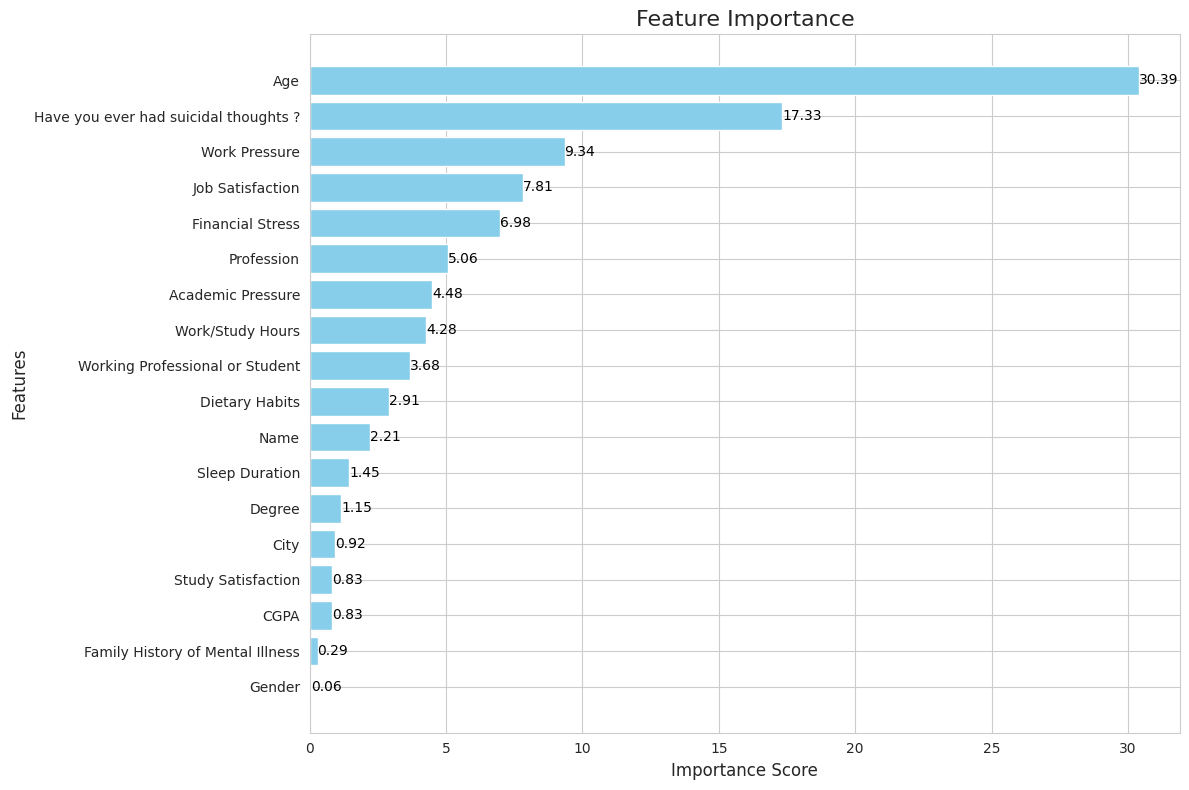

In [42]:
# Проверим важность фич, в catboost встроен метод feature importances, воспользуемся им и построем график

# Получаем важность признаков
feature_importance = model.feature_importances_

# Сортируем признаки по важности
sorted_idx = np.argsort(feature_importance)

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='skyblue')

# Добавление меток
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center', ha='left', color='black')

ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(np.array(X_test.columns)[sorted_idx])

ax.set_title('Feature Importance', fontsize=16)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

plt.tight_layout()

plt.show()

# Анализ графика позволяет сделать вывод, что наиболее важными факторами являются возраст и наличие суицидальных мыслей
# Аналогичные результаты мы получили в первой части моей работы

# В ходе исследования датасета Exploring Mental Health Data, полученного с платформы Kaggle, были выявлены закономерности, указывающие на значимость возраста и наличия суицидальных мыслей. Эти выводы подтверждены с помощью обученной модели градиентного бустинга, которая продемонстрировала эффективность в прогнозировании

# Таким образом, цель работы достигнута: простая модель градиентного бустинга позволила не только выявить ключевые закономерности в данных, но и достичь оптимальных показателей оценки качества модели